# Spatial spectra

Make wave-number spectra of various runs (based on Andrew's script https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/spectra/spectra.ipynb)

In [1]:
# import pyfftw # faster but not available - get this installed?
import numpy as np
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import copy
from scipy.fftpack import fft2, fftn, fftshift
import scipy.signal.windows as ssw
# import matplotlib.colors as colors
# import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
# from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
# import cmocean as cm

from collections import OrderedDict

import sys, os
from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:33350 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
# Load session 
session = cc.database.create_session('../cc_database_01degspec.db')
exptdict = OrderedDict([
    ('01degRYF',   {'model':'ACCESS-OM2-01', 'expt':'01deg_jra55_ryf',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('01degRYF8485',   {'model':'ACCESS-OM2-01-8485', 'expt':'01deg_jra55v13_ryf8485_spinup6',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('01degRYFhv',   {'model':'ACCESS-OM2-01-hvisc', 'expt':'01deg_jra55v13_ryf9091_k_smag_iso3',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('025degRYF',   {'model':'ACCESS-OM2-025-RG', 'expt':'025deg_jra55_ryf_rediGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    ('025degRYFnorediGM',   {'model':'ACCESS-OM2-025', 'expt':'025deg_jra55_ryf9091_gadi_norediGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    ('025degRYFnoGM',   {'model':'ACCESS-OM2-025-R', 'expt':'025deg_jra55_ryf9091_gadi_noGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
])

In [5]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
    # 'GulfStream':             [-85,-50,25,45],
    'Southern Ocean': [-250, -220, -60, -45] # Marine's region
}

In [6]:
# load model snapshots and grid data
kes = copy.deepcopy(exptdict)  # this will store KE fields under the same keys as exptdata.exptdict
for ekey in kes.keys():
        expt = kes[ekey]['expt']
        n_files = kes[ekey]['n_files']
        usnap = 'ocean_' + kes[ekey]['usnap'] + '.nc'
        tsnap = 'ocean_' + kes[ekey]['tsnap'] + '.nc'
        
        # Load zonal velocity
        try:
            tmp = cc.querying.getvar(expt, 'u',session,n=n_files, ncfile=usnap)
            u = tmp.isel(st_ocean=0)

            # Load meridional velocity
            tmp = cc.querying.getvar(expt, 'v',session,n=n_files, ncfile=usnap)
            #tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'v',n=n_files,use_cache=use_cache)
            v = tmp.isel(st_ocean=0)
            
            kes[ekey]['ke'] = (u**2+v**2).fillna(0.0)/2  # fill land with zeros 
            
            # Load dxu, dyu vectors (NOTE: Below will not work in Tripolar region):
            # kes[ekey]['dxu'] = cc.querying.getvar(expt,'dxu',session,n=-1, ncfile='ocean_grid.nc').mean('xu_ocean',skipna=True)
            # kes[ekey]['dyu'] = cc.querying.getvar(expt,'dyu',session,n=-1, ncfile='ocean_grid.nc').mean('xu_ocean',skipna=True)
        
            # Load area:
            # kes[ekey]['area_u'] = cc.querying.getvar(expt,'area_u',session,n=-1, ncfile='ocean_grid.nc')
            
            sz = np.shape(kes[ekey]['ke'])
            print('Found ' + str(sz[0]) + ' snapshots of velocity for ' + kes[ekey]['model'])
            
        except:
            print('Velocity snapshots not found ' + kes[ekey]['model'])
        
        # Load SST and temperature at depth
        try:
            tmp = cc.querying.getvar(expt, 'temp',session,n=n_files, ncfile=tsnap)
            
            #tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'v',n=n_files,use_cache=use_cache)
            SST = tmp.isel(st_ocean=0)-273.15                  
            kes[ekey]['SST'] = SST.fillna(0.0)
            
            T10 = tmp.sel(st_ocean=10.,method='nearest')-273.15                  
            kes[ekey]['T10'] = T10.fillna(0.0)
            
            T100 = tmp.sel(st_ocean=100.,method='nearest')-273.15                  
            kes[ekey]['T100'] = T100.fillna(0.0)
            T200 = tmp.sel(st_ocean=200.,method='nearest')-273.15                  
            kes[ekey]['T200'] = T200.fillna(0.0)
            T300 = tmp.sel(st_ocean=300.,method='nearest')-273.15                  
            kes[ekey]['T300'] = T300.fillna(0.0)
            T500 = tmp.sel(st_ocean=500.,method='nearest')-273.15                  
            kes[ekey]['T500'] = T500.fillna(0.0)
            
            # Load dxu and dyu vectors (NOTE: Below will not work in Tripolar region):
            # kes[ekey]['dxt'] = cc.querying.getvar(expt,'dxt',session,n=-1, ncfile='ocean_grid.nc').mean('xt_ocean',skipna=True)
            # kes[ekey]['dyt'] = cc.querying.getvar(expt,'dyt',session,n=-1, ncfile='ocean_grid.nc').mean('xt_ocean',skipna=True)
            
            # Load area:
            # kes[ekey]['area_t'] = cc.querying.getvar(expt,'area_t',session,n=-1, ncfile='ocean_grid.nc')
            
            sz = np.shape(kes[ekey]['SST'])
            print('Found ' + str(sz[0]) + ' snapshots of temperature for ' + kes[ekey]['model'])

        except:
            print('Temperature snapshots not found ' + kes[ekey]['model'])

Velocity snapshots not found ACCESS-OM2-01
Found 4 snapshots of temperature for ACCESS-OM2-01
Found 8 snapshots of velocity for ACCESS-OM2-01-8485
Temperature snapshots not found ACCESS-OM2-01-8485
Found 12 snapshots of velocity for ACCESS-OM2-01-hvisc
Found 4 snapshots of temperature for ACCESS-OM2-01-hvisc
Found 24 snapshots of velocity for ACCESS-OM2-025-RG
Found 24 snapshots of temperature for ACCESS-OM2-025-RG
Found 24 snapshots of velocity for ACCESS-OM2-025
Found 24 snapshots of temperature for ACCESS-OM2-025
Found 24 snapshots of velocity for ACCESS-OM2-025-R
Found 24 snapshots of temperature for ACCESS-OM2-025-R


In [7]:
def detrend(f,dim):
    """
    Detrend multidimensional dataarray f in dimension dim.
    In all other dimensions, remove linear function from first to last element in dimension given by string dim.
    Follows method of Errico1985a sec 2a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
    WARNING: can produce a plaid pattern that produces artifacts in fft. Better to use window instead.
    
    cf. ArbicPolzinScottRichmanShriver2013a - they detrend with a 2d least-squares fit (this won't ensure periodicity but doesn't introduce spurious patterns)
    """
    # I don't like using eval but I can't think of a better way right now...
    first = eval('f.isel('+dim+'=0)')
    last = eval('f.isel('+dim+'=-1)')
    n = f[dim].size
    slope = (last-first)/(n-1)
    scale = xr.DataArray(np.arange((1-n)/2,(n+1)/2), coords={dim: f[dim]}, dims=[dim])
    return f-scale*slope # subtract outer product    

In [14]:
# DRAFTING INTERPOLATION TO UNIFORM GRID
#def interp_to_uniform(var,dx,dy,area):
#    """
#    Interpolate variable onto a grid with uniform grid-spacing.
#    """
loc = locations['GulfStream']
var = kes['01degRYFhv']['SST'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1])).values
dx = kes['01degRYFhv']['dxt'].sel(yt_ocean=slice(loc[2],loc[3])).values
dy = kes['01degRYFhv']['dyt'].sel(yt_ocean=slice(loc[2],loc[3])).values
area = kes['01degRYFhv']['area_t'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1])).values
X = np.tile(dx.T, (len(var[0,0,:]),1)).cumsum(axis=0)
Y = np.tile(dy.T, (len(var[0,0,:]),1)).cumsum(axis=1)
Lx = np.max(X)
Ly = np.max(Y)
Ly
#X = X.cumsum(axis=0)
#Y = Y.cumsum(axis=1)
#plt.pcolormesh(X.T,Y.T,X.T)
#np.shape(var)

KeyError: 'dxt'

In [8]:
def window(f,dim,window='hamming'):
    """
    Apply window to multidimensional dataarray f in dimension dim.
    
    cf. ArbicPolzinScottRichmanShriver2013a http://dx.doi.org/10.1175/JPO-D-11-0240.1
    - they detrend with a 2d least-squares fit before windowing (and use a different window function)
    ScottWang2005a do something similar
    TullochMarshallHillSmith2011a use flipping instead to ensure periodicity
    """
    return f*xr.DataArray(ssw.get_window(window, f[dim].size), coords={dim: f[dim]}, dims=[dim])

In [59]:
def fftgrid(v2):
    """
    FFT squared magnitude, in grid space
    """
    tdim, ydim, xdim = v2.dims  # abstract out dimension names - NB: assumes this order of dimensions
    nx = v2[xdim].size
    ny = v2[ydim].size

#     v2dt = detrend(detrend(v2,'xt_ocean'),'yt_ocean')  # don't use - produces artifacts
    v2dt = window(window(v2,xdim),ydim)
    v2dt = v2dt-v2dt.mean(xdim, skipna=True).mean(ydim, skipna=True)

#     fig = plt.figure(figsize=(12,8))
#     v2dt.isel(time=0).plot()
#     plt.title(locname+' surface enstrophy, windowed, demeaned')

#    v2dtfft = abs(fftn(v2dt, axes=(1,2)))**2  # fft squared amplitude at each time
    v2dtfft = abs(fftn(v2dt.values, axes=(1,2)))  # fft amplitude at each time

    v2dtfft = v2dtfft.mean(axis=0)  # time-mean
    v2dtfft[0,0] = np.nan  # nan at removed zero frequency
    v2dtfft = fftshift(v2dtfft)  # put zero wavenumber in array centre

    v2dtfft = xr.DataArray(v2dtfft, dims=['kj','ki'], 
                coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                attrs={'long_name': 'wavenumber spectrum in grid units'})
    v2dtfft.ki.attrs['units'] = 'cycles/dx'
    v2dtfft.kj.attrs['units'] = 'cycles/dy'
    v2dtfft.ki.attrs['long_name'] = 'x wavenumber'
    v2dtfft.kj.attrs['long_name'] = 'y wavenumber'
    return v2dtfft

In [10]:
def azimuthal_sum(v2dtfft):
    annuli = np.linspace(0.0, 0.5, num=int(min(v2dtfft.shape)/2.0))
    v2dtfftradialcsum = 0.0*annuli
    for i,a in enumerate(annuli[1:]):
        v2dtfftradialcsum[i+1] = v2dtfft.where(np.sqrt(v2dtfft.ki**2+v2dtfft.kj**2)<a).sum()
    v2dtfftradial = np.diff(v2dtfftradialcsum)
    v2dtfftradial = xr.DataArray(v2dtfftradial, dims=['k'], coords={'k': annuli[1:]})
    v2dtfftradial.k.attrs['units'] = 'cycles/dx'
    v2dtfftradial.k.attrs['long_name'] = 'wavenumber magnitude'
    return v2dtfftradial

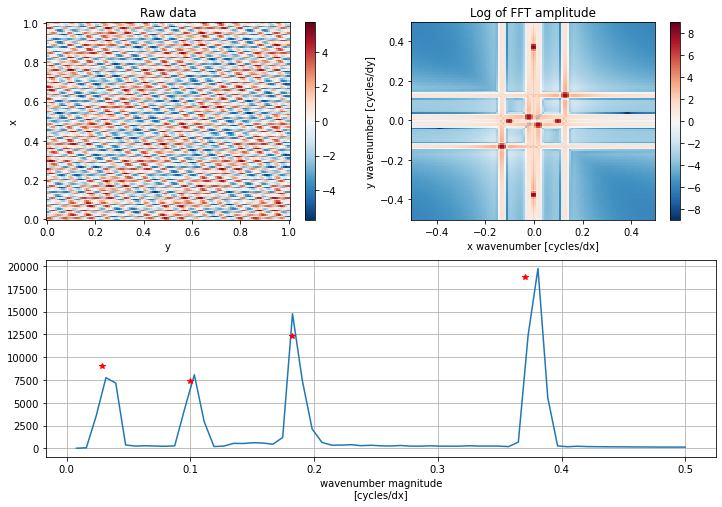

In [64]:
# Testing with dummy data

# dimensions
xL, yL = 128, 128
x, y = np.linspace(0.,1.,xL),np.linspace(0.,1.,yL)
dx, dy = 1./xL, 1./yL
X, Y = np.meshgrid(x,y)
t = [0]

# dummy solution
k1, k2, kx, ky = 2.*np.pi/(5.5*dx), 2.*np.pi/(35.*dx), 2.*np.pi/(10.*dx), 2.*np.pi/(2.7*dx)
a1, a2, ax, ay = 1.5, 1.1, 0.9, 2.3
data = np.zeros((1,xL,yL))
data[0,:,:] = a1*np.sin(k1*(X+Y)/np.sqrt(2.)) + a2*np.sin(k2*(X-Y)/np.sqrt(2.)) + ax*np.sin(kx*X) + ay*np.sin(ky*Y)

# calc/plot spectra
dummy = xr.DataArray(data,coords=[t,x,y],dims=['t','x','y'])

fft = fftgrid(dummy)
fftradial = azimuthal_sum(fft)

fig2 = plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
dummy.plot()
plt.title('Raw data')
plt.subplot(2,2,2)
np.log(fft).plot()
plt.title('Log of FFT amplitude')
plt.subplot(2,2,(3,4))
fftradial.plot()
#mxmn = [np.min(fftradial),np.max(fftradial)]
#plt.plot([k1*dx/2./np.pi,k1*dx/2./np.pi],mxmn,'-r')
#plt.plot([k2*dx/2./np.pi,k2*dx/2./np.pi],mxmn,'-r')
#plt.plot([kx*dx/2./np.pi,kx*dx/2./np.pi],mxmn,'-r')
#plt.plot([ky*dx/2./np.pi,ky*dx/2./np.pi],mxmn,'-r')
plt.plot([k1*dx/2./np.pi],[a1*xL*xL/2.],'*r')
plt.plot([k2*dx/2./np.pi],[a2*xL*xL/2.],'*r')
plt.plot([kx*dx/2./np.pi],[ax*xL*xL/2.],'*r')
plt.plot([ky*dx/2./np.pi],[ay*xL*xL/2.],'*r')
plt.grid()

Velocity snapshots not found ACCESS-OM2-01
Temperature snapshots not found ACCESS-OM2-01-8485


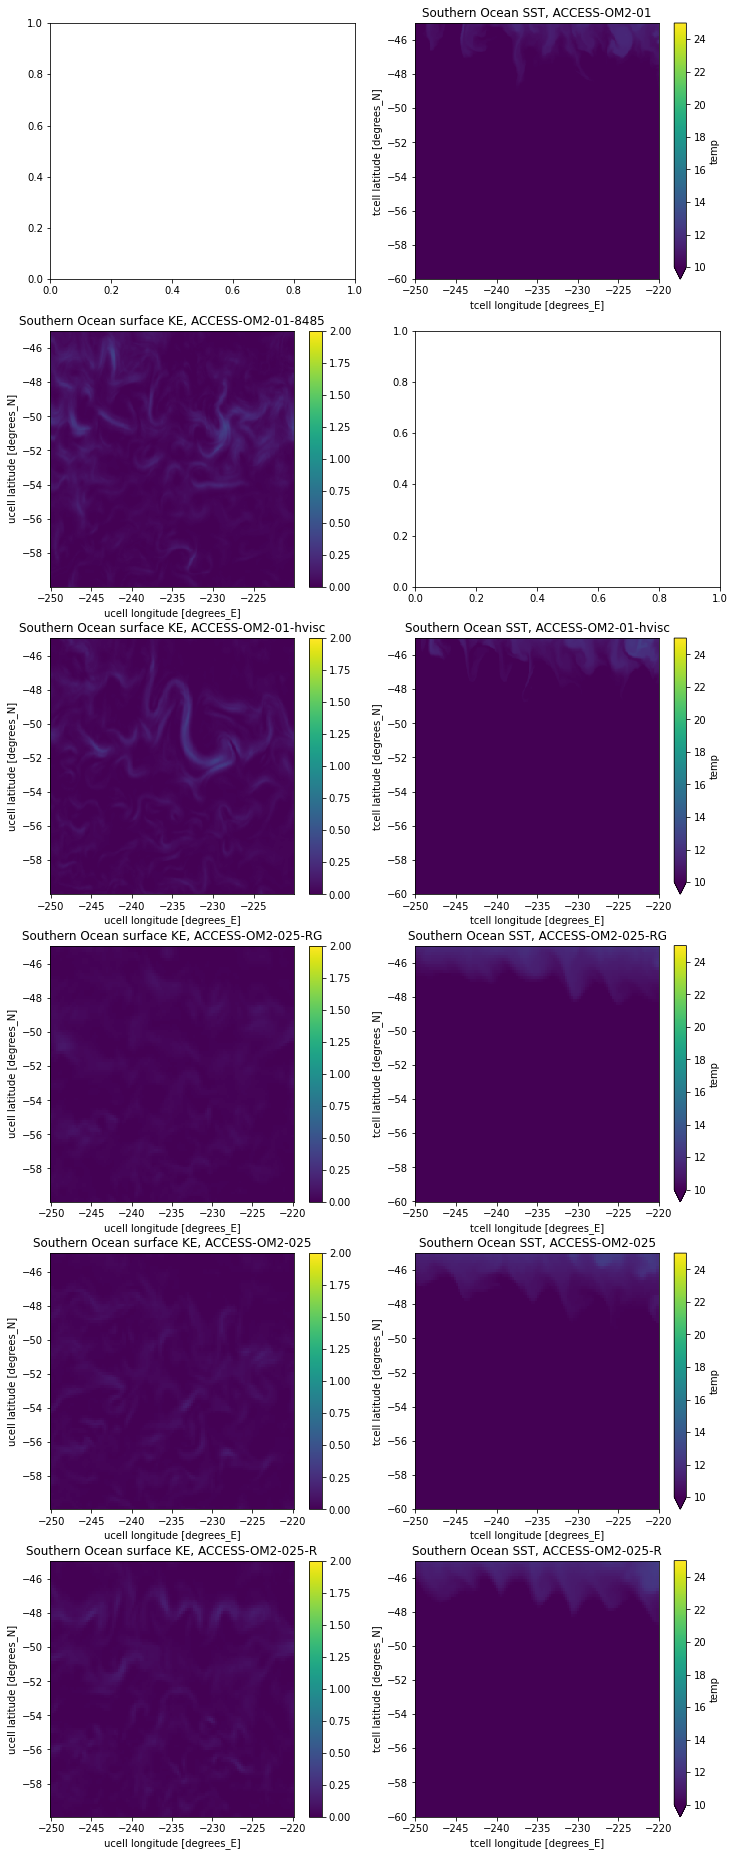

In [49]:
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,5.5*len(kes.keys())))
    cnt = 0
    for ekey in kes.keys():
        ax1 = plt.subplot(len(kes.keys()),2,1+2*cnt)
        ax2 = plt.subplot(len(kes.keys()),2,2+2*cnt)
        cnt = cnt+1
        try:
            ke = kes[ekey]['ke'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))

            ke.isel(time=0).plot(ax=ax1,vmin=0.,vmax=2.)
            ax1.set_title(locname+' surface KE, '+kes[ekey]['model'])

            kefft = fftgrid(ke)

            #fig2 = plt.figure(figsize=(12,8))
            #np.log(kefft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
            #plt.title(locname+' log of time-mean surface KE FFT amplitude, '+kes[ekey]['model'])

            kefftradial = azimuthal_sum(kefft)
            kes[ekey]['kefftradial'] = kefftradial
        except:
            print('Velocity snapshots not found ' + kes[ekey]['model'])
            
        try:
            SST = kes[ekey]['SST'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            T10 = kes[ekey]['T10'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            T100 = kes[ekey]['T100'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            T200 = kes[ekey]['T200'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            T300 = kes[ekey]['T300'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            T500 = kes[ekey]['T500'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            
            SST.isel(time=0).plot(ax=ax2,vmin=10.,vmax=25.)
            ax2.set_title(locname+' SST, '+kes[ekey]['model'])

            SSTfft = fftgrid(SST)
            SSTfftradial = azimuthal_sum(SSTfft)
            kes[ekey]['SSTfftradial'] = SSTfftradial
            
            T10fft = fftgrid(T10)
            T10fftradial = azimuthal_sum(T10fft)
            kes[ekey]['T10fftradial'] = T10fftradial
            
            T100fft = fftgrid(T100)
            T100fftradial = azimuthal_sum(T100fft)
            kes[ekey]['T100fftradial'] = T100fftradial
            
            T200fft = fftgrid(T200)
            T200fftradial = azimuthal_sum(T200fft)
            kes[ekey]['T200fftradial'] = T200fftradial
            
            T300fft = fftgrid(T300)
            T300fftradial = azimuthal_sum(T300fft)
            kes[ekey]['T300fftradial'] = T300fftradial
            
            T500fft = fftgrid(T500)
            T500fftradial = azimuthal_sum(T500fft)
            kes[ekey]['T500fftradial'] = T500fftradial
            # fig2 = plt.figure(figsize=(12,8))
            # np.log(SSTfft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
            # plt.title(locname+' log of time-mean SST FFT amplitude, '+kes[ekey]['model'])

            
        except:
            print('Temperature snapshots not found ' + kes[ekey]['model'])

KE spectra not plotted ACCESS-OM2-01
SST spectra not plotted ACCESS-OM2-01-8485


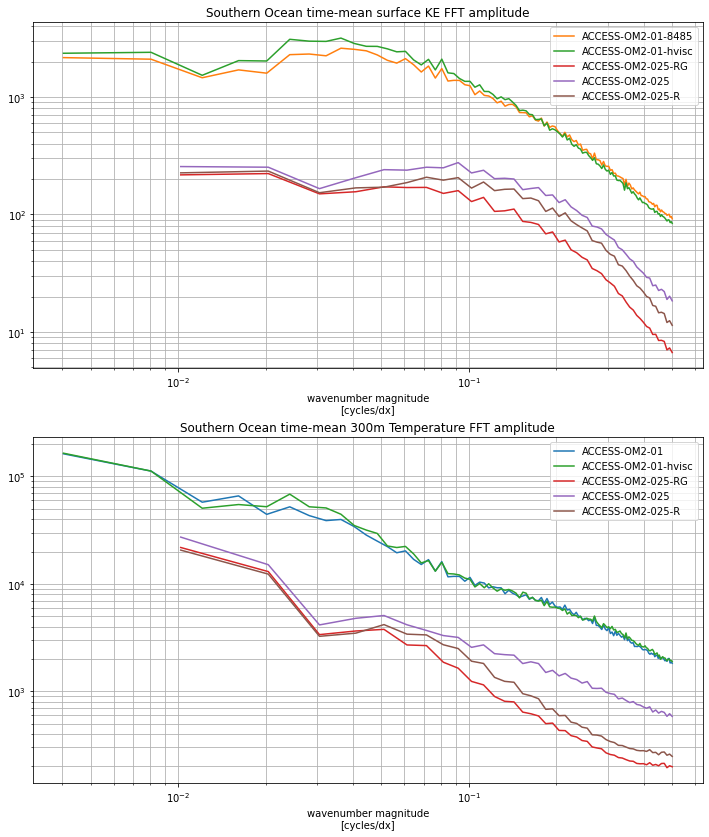

In [57]:
# Plot spectra together:            
fig3 = plt.figure(figsize=(12,14))
axs1 = plt.subplot(2,1,1)
axs2 = plt.subplot(2,1,2)
for locname,loc in locations.items():
    cnt=0
    for ekey in kes.keys():
        col = 'C' + str(cnt)
        cnt = cnt+1
        try:
            kefftradial = kes[ekey]['kefftradial']
            kefftradial.plot(ax=axs1, xscale='log', yscale='log',label=kes[ekey]['model'],color=col)
            axs1.set_title(locname+' time-mean surface KE FFT amplitude')
        except:
            print('KE spectra not plotted ' + kes[ekey]['model'])
        try:          
            SSTfftradial = kes[ekey]['SSTfftradial']
            #SSTfftradial.plot(ax=axs2, xscale='log', yscale='log',label=kes[ekey]['model'],color=col)
            
            # kes[ekey]['T10fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='--',color=col)
            # kes[ekey]['T100fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='--',color=col)
            # kes[ekey]['T200fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='--',color=col)
            kes[ekey]['T300fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='-',color=col,label=kes[ekey]['model'],)
            #kes[ekey]['T500fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle=':',color=col)
            axs2.set_title(locname+' time-mean 300m Temperature FFT amplitude')

        except:
            print('SST spectra not plotted ' + kes[ekey]['model'])

axs1.grid(which='both', axis='both')
axs1.legend()
axs2.grid(which='both', axis='both')
axs2.legend()
#axs2.text(1.01e-2,1.e3,'solid=SST \ndashed=300m \ndotted=500m')
#axs2.set_ylim([5.e3, 4.e5])
savefigure(locname+'SpectraSimple')

# TODO
- first test with dummy data with known spectral content
- interpolate onto grid in units of metres (choose a power of 2)
- remove trends from interpolated data - see Errico1985a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
- remove mean (do this with interpolated data so it is area-weighted)
- 2d FFT
- calc squared magnitude
- convert to spectrum wrt |k| - see DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
